In [2]:
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [3]:
# run_path = r"/netfiles/ciroh/floodplainsData/runs/8/run_metadata.json"
run_path = r"/netfiles/ciroh/floodplainsData/runs/9/run_metadata.json"
with open(run_path, 'r') as f:
    run_dict = json.loads(f.read())

# Load results data
results = pd.read_csv(run_dict['analysis_path'])
results['UVM_ID'] = results['UVM_ID'].astype(str)
results = results.set_index(run_dict['id_field'])
clusters = pd.read_csv(os.path.join(run_dict['analysis_directory'], 'clustering', 'clustered_features.csv'))
clusters['UVM_ID'] = clusters['UVM_ID'].astype(str)
clusters = clusters.set_index(run_dict['id_field'])
subset = ['A', 'B', 'C', 'D', 'E', 'F']
results = results.join(clusters['cluster'], how='inner')

In [4]:
c1 = '#32d4e6'
c2 = '#faa319'
background_color = '#f0f0f0'

# pt_size = 7
# pt_alpha = 0.5
pt_size = 4
pt_alpha = 0.75

scale_size = 8
aspect = 9 / 13
w = scale_size
h = scale_size * aspect

mag_renames = {'Q2': '0.5AEP', 'Q10': '0.1AEP', 'Q50': '0.02AEP', 'Q100': '0.01AEP'}
mags = ['Q2', 'Q100']


In [5]:
for m in mags:
    results[f'{m}_Medium_pct_attenuation_per_km'] = results[f'{m}_Medium_pct_attenuation_per_km'] * 100

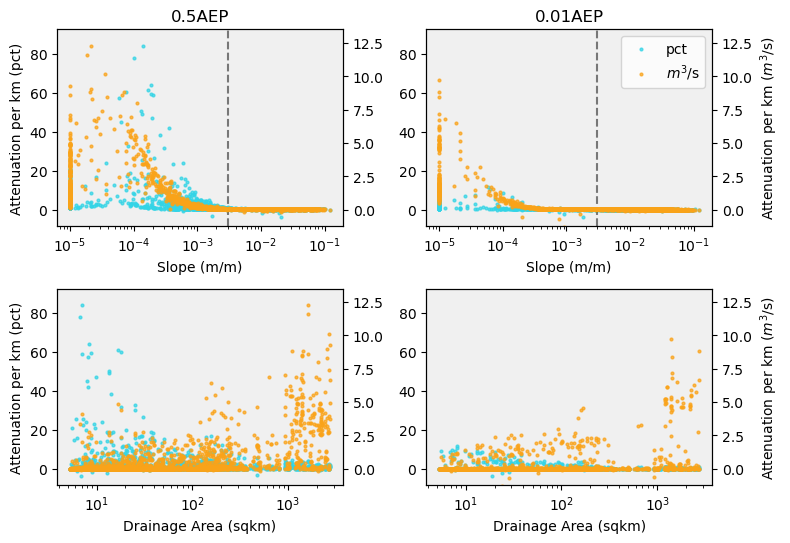

In [6]:
lowess = sm.nonparametric.lowess
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(w, h))

y1_max = max([results[f'{m}_Medium_pct_attenuation_per_km'].max() for m in mags])
y2_max = max([results[f'{m}_Medium_cms_attenuation_per_km'].max() for m in mags])
y1_min = 0
y2_min = 0
# math to make 0 line up between the two axes
y1_range = y1_max - y1_min
y2_range = y2_max - y2_min
r1 = (y1_min / y1_range)
r2 = (y2_min / y2_range)
if abs(r1) > abs(r2):
    y2_min = (r1 * y2_max) / (1 + r1)
else:
    y1_min = (r2 * y1_max) / (1 + r2)
y1_range = y1_max - y1_min
y2_range = y2_max - y2_min
# add buffer
y1_max += 0.1*y1_range
y2_max += 0.1*y2_range
y1_min -= 0.1*y1_range
y2_min -= 0.1*y2_range

for ind, m in enumerate(mags):
    # Panel 1:  slope vs attenuation
    x = results['slope']
    y1 = results[f'{m}_Medium_pct_attenuation_per_km']
    y2 = results[f'{m}_Medium_cms_attenuation_per_km']
    pct_label = axs[0, ind].scatter(x, y1, c=c1, s=pt_size, alpha=pt_alpha)
    # z = lowess(y1, x)
    # axs[0, ind].plot(z[:, 0], z[:, 1], c='b')
    ax_00_twin = axs[0, ind].twinx()
    cms_label = ax_00_twin.scatter(x, y2, c=c2, s=pt_size, alpha=pt_alpha)
    # z = lowess(y2, x)
    # ax_00_twin.plot(z[:, 0], z[:, 1], c='r')
    axs[0, ind].axvline(x=3e-3, c='k', ls='--', alpha=0.5)
    axs[0, ind].set(ylim=(y1_min, y1_max), title=mag_renames[m], xlabel='Slope (m/m)', xscale='log', facecolor=background_color)
    ax_00_twin.set(ylim=(y2_min, y2_max), facecolor=background_color)
    if ind == 0:
        axs[0, ind].set(ylabel='Attenuation per km (pct)')
    else:
        ax_00_twin.set(ylabel=r'Attenuation per km (${m}^{3}$/s)')

    # Panel 2:  DA vs attenuation
    x = results['DASqKm']
    axs[1, ind].scatter(x, y1, c=c1, s=pt_size, alpha=pt_alpha)
    # z = lowess(y1, x)
    # axs[1, ind].plot(z[:, 0], z[:, 1], c='b')
    ax_10_twin = axs[1, ind].twinx()
    ax_10_twin.scatter(x, y2, c=c2, s=pt_size, alpha=pt_alpha)
    # z = lowess(y2, x)
    # ax_10_twin.plot(z[:, 0], z[:, 1], c='r')
    axs[1, ind].set(ylim=(y1_min, y1_max), xlabel='Drainage Area (sqkm)', xscale='log', facecolor=background_color)
    ax_10_twin.set(ylim=(y2_min, y2_max), facecolor=background_color)
    if ind == 0:
        axs[1, ind].set(ylabel='Attenuation per km (pct)')
    else:
        ax_10_twin.set(ylabel=r'Attenuation per km (${m}^{3}$/s)')

    axs[0, 1].legend([pct_label, cms_label], ['pct', r'${m}^{3}$/s'], loc='upper right')
fig.tight_layout()
plt.show()

In [7]:
out_path = os.path.join(run_dict['analysis_directory'], 'clustering', 'final', 'Figure_8.png')
fig.savefig(out_path, dpi=400)

out_path = os.path.join(run_dict['analysis_directory'], 'clustering', 'final', 'Figure_8.pdf')
fig.savefig(out_path, dpi=400)

In [11]:
(results['Q2_Medium_pct_attenuation_per_km'] < y1_min).sum()

2